# Part 3: Entraînement, Interprétation du modèle et Déploiement


**Objectifs pédagogiques**
- Charger les données prétraitées et les résultats d’Optuna
- Entraîner le modèle LightGBM avec les meilleurs paramètres trouvés
- Évaluer les performances sur le jeu de test
- Interpréter le modèle à l'aide de SHAP pour comprendre l’impact des variables
- Optimiser le seuil de décision et calibrer le modèle
- Préparer l’export pour la mise en production

In [1]:
# 1. Imports nécessaires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor

/Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1️. Charger les données complètes & paramètres

In [2]:
## paths
#folder_path_M = '/Users/maximehenon/Documents/GitHub/MAR25_BDS_Compagnon_Immo/'
# folder_path_Y = 'C:/Users/charl/OneDrive/Documents/Yasmine/DATASCIENTEST/FEV25-BDS-COMPAGNON'
#folder_path_C = '../data/processed/Sales'
folder_path_L= '/Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/'
# folder_path_LW = 'C:/Users/User/Downloads/drive-download-20250508T155351Z-1-001'


# Load the dataset
#output_file = os.path.join(folder_path_M, 'df_sales_clean.csv')
# output_file = os.path.join(folder_path_Y, 'df_sales_clean.csv')
#output_file = os.path.join(folder_path_C, 'df_sales_clean.csv')
output_file = os.path.join(folder_path_L, 'df_sales_clean_with_cluster.csv')
# output_file = os.path.join(folder_path_LW, 'df_sales_clean_with_cluster.csv')

chunksize = 100000  # Number of rows per chunk
chunks = pd.read_csv(output_file, sep=';', chunksize=chunksize, index_col=None, on_bad_lines='skip', low_memory=False)
# Process chunks
df_sales_clean = pd.concat(chunk for chunk in chunks)
df = df_sales_clean

## Rappel des colonnes restantes
# print("Colonnes restantes dans le DataFrame :")
# print(df_sales_clean.columns)
# print(df_sales_clean.dtypes)
# print("\nShape du Dataset après élimination des colonnes :", df_sales_clean.shape)
print(df_sales_clean.info())

# Charger les meilleurs paramètres de la Part 2
best_params = joblib.load("best_lgbm_params.pkl")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023283 entries, 0 to 1023282
Data columns (total 54 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   typedebien                   1023283 non-null  object 
 1   typedetransaction            1023283 non-null  object 
 2   etage                        1023283 non-null  int64  
 3   surface                      1023283 non-null  int64  
 4   surface_terrain              518612 non-null   float64
 5   nb_pieces                    1023283 non-null  int64  
 6   balcon                       1023283 non-null  int64  
 7   eau                          1023283 non-null  int64  
 8   bain                         1023283 non-null  int64  
 9   dpeL                         873421 non-null   object 
 10  dpeC                         667571 non-null   float64
 11  mapCoordonneesLatitude       1023283 non-null  float64
 12  mapCoordonneesLongitude      1023283 non-n

# 2. Préparer les données

In [3]:
# Préparer les données
X = df.drop(columns=['prix_m2_vente'])  # Supprimer la colonne cible
y = df['prix_m2_vente']  # Utiliser la colonne cible

# 3. Créer le pipeline

In [4]:
# ─── 0. Fonction d'encodage cyclique des dates ────────────────────────────────
def cyclical_encode(df):
    df = df.copy()
    # Assurer que 'date' est datetime64
    df["date"] = pd.to_datetime(df["date"])
    # Extraire composantes
    df["month"] = df["date"].dt.month      # 1–12
    df["dow"]   = df["date"].dt.weekday    # 0–6
    df["hour"]  = df["date"].dt.hour       # 0–23

    # Appliquer sin/cos pour chaque périodicité
    for col, period in [("month", 12), ("dow", 7), ("hour", 24)]:
        df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / period)
        df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / period)
        df.drop(columns=[col], inplace=True)

    # On n'a plus besoin de la colonne brute 'date'
    df.drop(columns=["date"], inplace=True)
    return df

# ─── 1. Déclarations des colonnes ──────────────────────────────────────────────
target_variable = "prix_m2_vente"
ordinal_cols  = ["ges_class", "dpeL", "logement_neuf", "nb_pieces", "bain", "eau", "nb_toilettes", "balcon"]
onehot_cols   = ["typedebien", "typedetransaction", "chauffage_mode", "chauffage_energie_principal", "cluster"]
target_cols   = ["etage", "nb_etages", "exposition", "chauffage_energie", "chauffage_systeme"]
numeric_cols  = ["surface", "surface_terrain", "dpeC", "places_parking", "charges_copro",
                 "loyer_m2_median_n6", "nb_log_n6", "taux_rendement_n6",
                 "loyer_m2_median_n7", "nb_log_n7", "taux_rendement_n7"]
geo_cols      = ["x_geo", "y_geo", "z_geo"]
year_col      = ["annee_construction"]
year_order = [
    "après 2021", "2013-2021", "2006-2012", "2001-2005",
    "1989-2000", "1983-1988", "1978-1982", "1975-1977",
    "1948-1974", "avant 1948"
]


In [5]:
# ─── 2. Pipelines & ColumnTransformer ─────────────────────────────────────────

# — Pipeline ordinal « classiques »
ordinal_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )),
    ("scale",  StandardScaler())
])

# — Pipeline one-hot
onehot_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore", sparse_output=False
    ))
])

# — Pipeline target-encoding
target_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("target", TargetEncoder()),
    ("scale",  StandardScaler())
])

# — Pipeline numérique
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

# — Pipeline géo
geo_pipeline = Pipeline([
    ("scale", StandardScaler())
])

def add_one(X):
    return X + 1

def invert_values(X):
    return 11 - X

def replace_neg1_with_5(x):
    return np.where(x == -1, 5, x)

# Pipeline « rank + inversion + scale »
year_rank_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(
        categories=[year_order],
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    )),
    ("replace_neg1", FunctionTransformer(replace_neg1_with_5)),  # ✅ VIRGULE ici
    ("plus1", FunctionTransformer(add_one)),
    ("invert", FunctionTransformer(invert_values)),
    ("scale", StandardScaler())
])
date_pipeline = Pipeline([
    ("cyclic", FunctionTransformer(cyclical_encode, validate=False))
])

# 4. Assemblage du pipeline complet

Nous assemblons maintenant tous les pipelines individuels en un seul transformateur de colonnes, qui sera ensuite intégré dans un pipeline complet avec notre modèle LightGBM configuré avec les meilleurs paramètres.

In [6]:
# ─── 5. Assembleur final ─────────────────────────────────────────────────────
preprocessor = ColumnTransformer(
    [
        ("ord",  ordinal_pipeline,   ordinal_cols),
        ("ohe",  onehot_pipeline,    onehot_cols),
        ("year", year_rank_pipeline, year_col),
        ("tar",  target_pipeline,    target_cols),
        ("num",  numeric_pipeline,   numeric_cols),
        ("geo",  geo_pipeline,       geo_cols),
        ("date", date_pipeline,      ["date"]),  # <-- pipeline date ajouté
    ],
    remainder="drop"  # on écarte tout le reste
)

# ─── Fonction utilitaire pour récupérer les noms de features transformés ──────
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(trans, 'get_feature_names_out'):
                try:
                    names = trans.get_feature_names_out()
                except TypeError:
                    names = trans.get_feature_names_out(cols)
                except:
                    names = cols
            elif hasattr(trans, 'named_steps'):
                last_step = list(trans.named_steps.values())[-1]
                if hasattr(last_step, 'get_feature_names_out'):
                    try:
                        names = last_step.get_feature_names_out(cols)
                    except:
                        names = cols
                else:
                    names = cols
            else:
                names = cols
            feature_names.extend(names)
        else:
            if trans == 'passthrough':
                feature_names.extend(cols)
    return feature_names

# 5. Entraînement du modèle

Nous entraînons maintenant notre modèle sur l'ensemble des données. Cette étape peut prendre un certain temps en raison de la taille du jeu de données et de la complexité du modèle.

In [7]:
# Entraînement du modèle sur l'ensemble des données
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", LGBMRegressor())
])
pipeline.set_params(**best_params)

print("Entraînement du modèle terminé.")

Entraînement du modèle terminé.


# 6. Split train/test (80/20)

In [8]:
# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
)

# Création des colonnes géographiques
# Pour X_train
lat_rad_train = np.radians(X_train['mapCoordonneesLatitude'].values)
lon_rad_train = np.radians(X_train['mapCoordonneesLongitude'].values)
X_train['x_geo'] = np.cos(lat_rad_train) * np.cos(lon_rad_train)
X_train['y_geo'] = np.cos(lat_rad_train) * np.sin(lon_rad_train)
X_train['z_geo'] = np.sin(lat_rad_train)

# Pour X_test
lat_rad_test = np.radians(X_test['mapCoordonneesLatitude'].values)
lon_rad_test = np.radians(X_test['mapCoordonneesLongitude'].values)
X_test['x_geo'] = np.cos(lat_rad_test) * np.cos(lon_rad_test)
X_test['y_geo'] = np.cos(lat_rad_test) * np.sin(lon_rad_test)
X_test['z_geo'] = np.sin(lat_rad_test)

# Vérification
print("Colonnes géographiques créées dans X_train :")
print(X_train[['x_geo', 'y_geo', 'z_geo']].head())
print("\nColonnes géographiques créées dans X_test :")
print(X_test[['x_geo', 'y_geo', 'z_geo']].head())

Colonnes géographiques créées dans X_train :
           x_geo     y_geo     z_geo
646279  0.695339  0.058838  0.716269
592166  0.727549 -0.004357  0.686042
912972  0.659573  0.027191  0.751148
485402  0.715392  0.005293  0.698703
258187  0.716126  0.050753  0.696123

Colonnes géographiques créées dans X_test :
            x_geo     y_geo     z_geo
1002928  0.529896  0.769362 -0.356782
972035   0.658558  0.027516  0.752027
760842   0.656808  0.031128  0.753415
721034   0.657468  0.026048  0.753032
565798   0.652793  0.029233  0.756972


# 7. Entraînenement

In [9]:
# Entraîner sur le dataset complet
pipeline.fit(X_train, y_train)
print("✅ Entraînement terminé sur le dataset complet")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 818626, number of used features: 54
[LightGBM] [Info] Start training from score 3551.791223
✅ Entraînement terminé sur le dataset complet


In [15]:
feature_names = get_feature_names_from_column_transformer(pipeline.named_steps["preproc"])
print(f"Nombre de features attendues par le modèle : {len(feature_names)}")
print(feature_names)

Nombre de features attendues par le modèle : 54
['ges_class', 'dpeL', 'logement_neuf', 'nb_pieces', 'bain', 'eau', 'nb_toilettes', 'balcon', 'typedebien_Maison/Villa neuve', 'typedebien_a', 'typedebien_an', 'typedebien_h', 'typedebien_l', 'typedebien_m', 'typedebien_mn', 'typedetransaction_pi', 'typedetransaction_v', 'typedetransaction_vp', 'chauffage_mode_Central', 'chauffage_mode_Collectif', 'chauffage_mode_Collectif, Central', 'chauffage_mode_Collectif, Individuel', 'chauffage_mode_Collectif, Individuel, Central', 'chauffage_mode_Individuel', 'chauffage_mode_Individuel, Central', 'chauffage_energie_principal_Bois', 'chauffage_energie_principal_Fioul', 'chauffage_energie_principal_Gaz', 'chauffage_energie_principal_Électrique', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'annee_construction', 0, 1, 2, 3, 4, 'surface', 'surface_terrain', 'dpeC', 'places_parking', 'charges_copro', 'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6', 'loyer_m2_median_n7', 'nb_log_n7', 'taux_r

# 8. Évaluation

/Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



📊 Métriques d'évaluation:
RMSE: 463.37
R²: 0.963


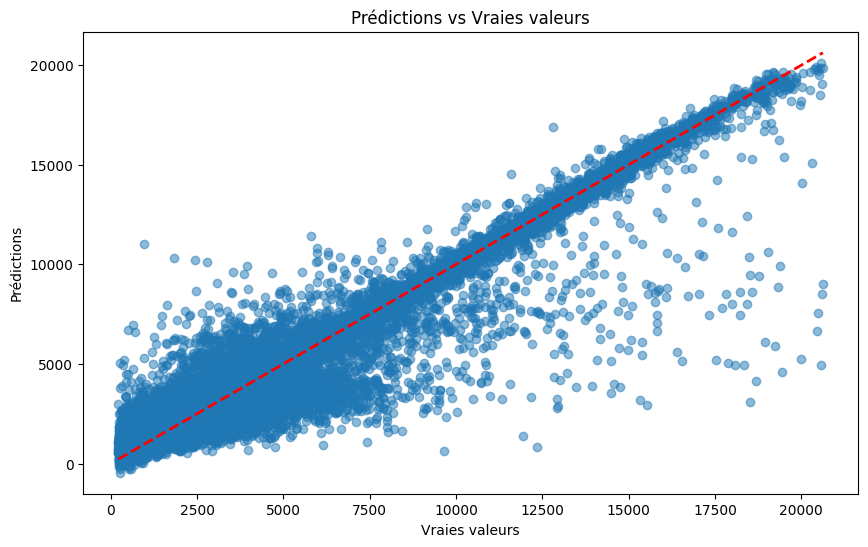

In [11]:
# 7. Évaluation
y_pred = pipeline.predict(X_test)

# Métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Métriques d'évaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# 8. Visualisation des prédictions vs vraies valeurs
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Vraies valeurs')
plt.show()

# 9. Interprétation avec SHAP


🔍 Calcul des valeurs SHAP...

📊 Visualisation des valeurs SHAP...


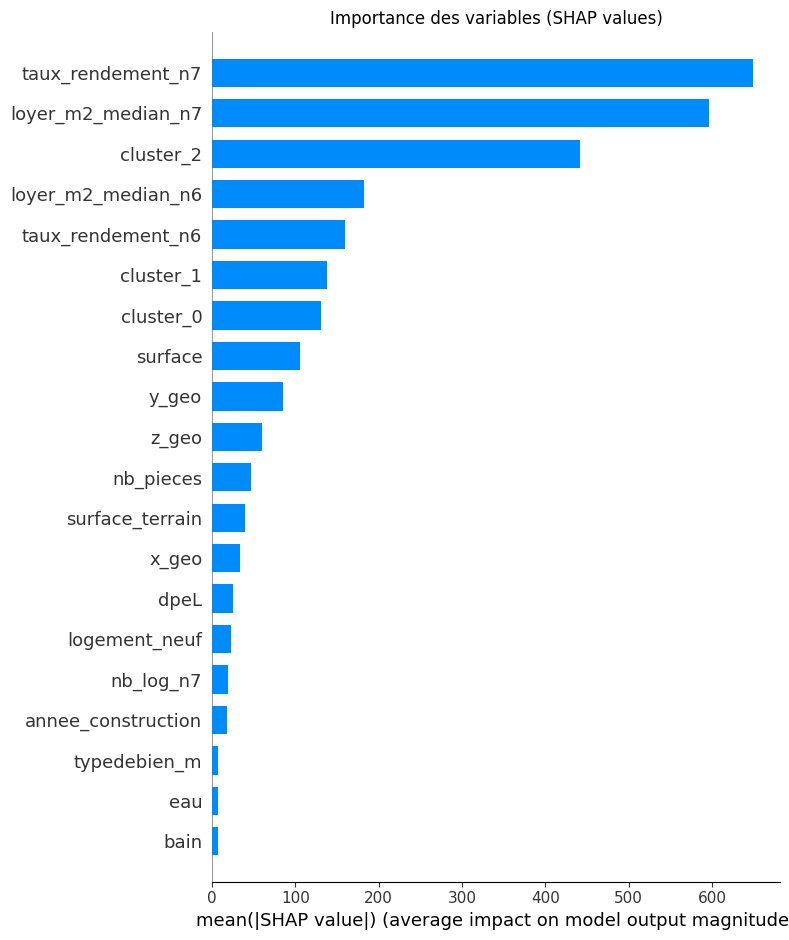

<Figure size 1000x600 with 0 Axes>

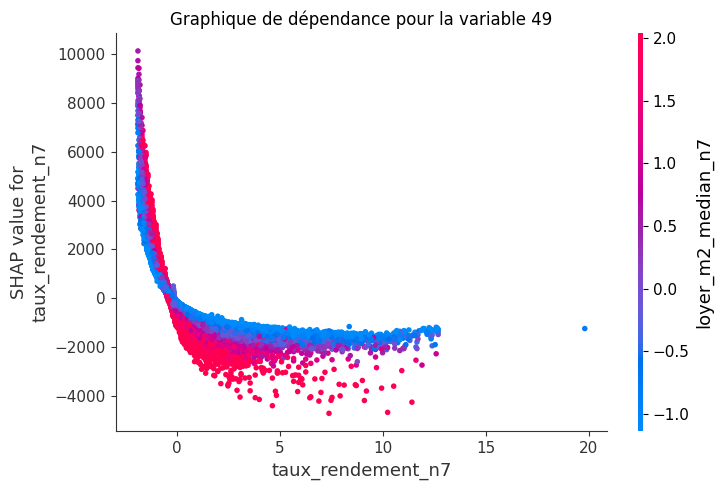

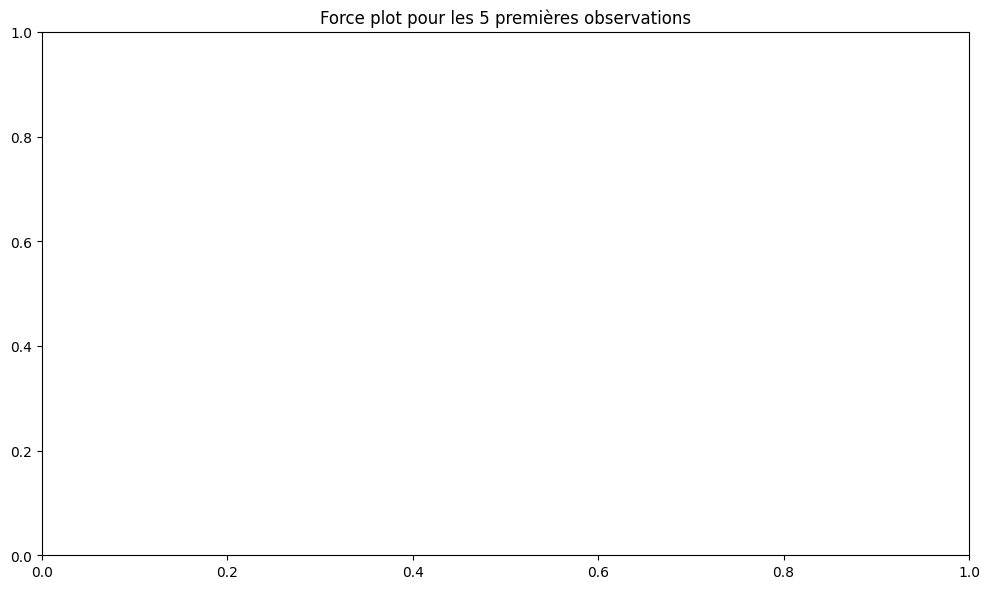

In [19]:
# 9. Interprétation avec SHAP
print("\n🔍 Calcul des valeurs SHAP...")
explainer = shap.TreeExplainer(pipeline.named_steps["model"])
X_test_trans = pipeline.named_steps["preproc"].transform(X_test)
shap_values = explainer.shap_values(X_test_trans)

# Récupération des vrais noms de features
feature_names = get_feature_names_from_column_transformer(pipeline.named_steps["preproc"])

# Visualisation des valeurs SHAP
print("\n📊 Visualisation des valeurs SHAP...")

# 1. Résumé des valeurs SHAP
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_trans,
    feature_names=feature_names,
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title("Importance des variables (SHAP values)")
plt.tight_layout()
plt.show()

# 2. Graphique de dépendance pour la variable la plus importante
most_important_feature = np.abs(shap_values).mean(0).argmax()

plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature, shap_values, X_test_trans, feature_names=feature_names,
                    show=False)
plt.title(f"Graphique de dépendance pour la variable {most_important_feature}")
plt.tight_layout()
plt.show()

# 3. Force plot pour quelques observations
plt.figure(figsize=(10, 6))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_trans[0], feature_names=feature_names)
plt.title("Force plot pour les 5 premières observations")
plt.tight_layout()
plt.show()

⚠️ 5 noms de features manquants, complétés par des noms génériques.


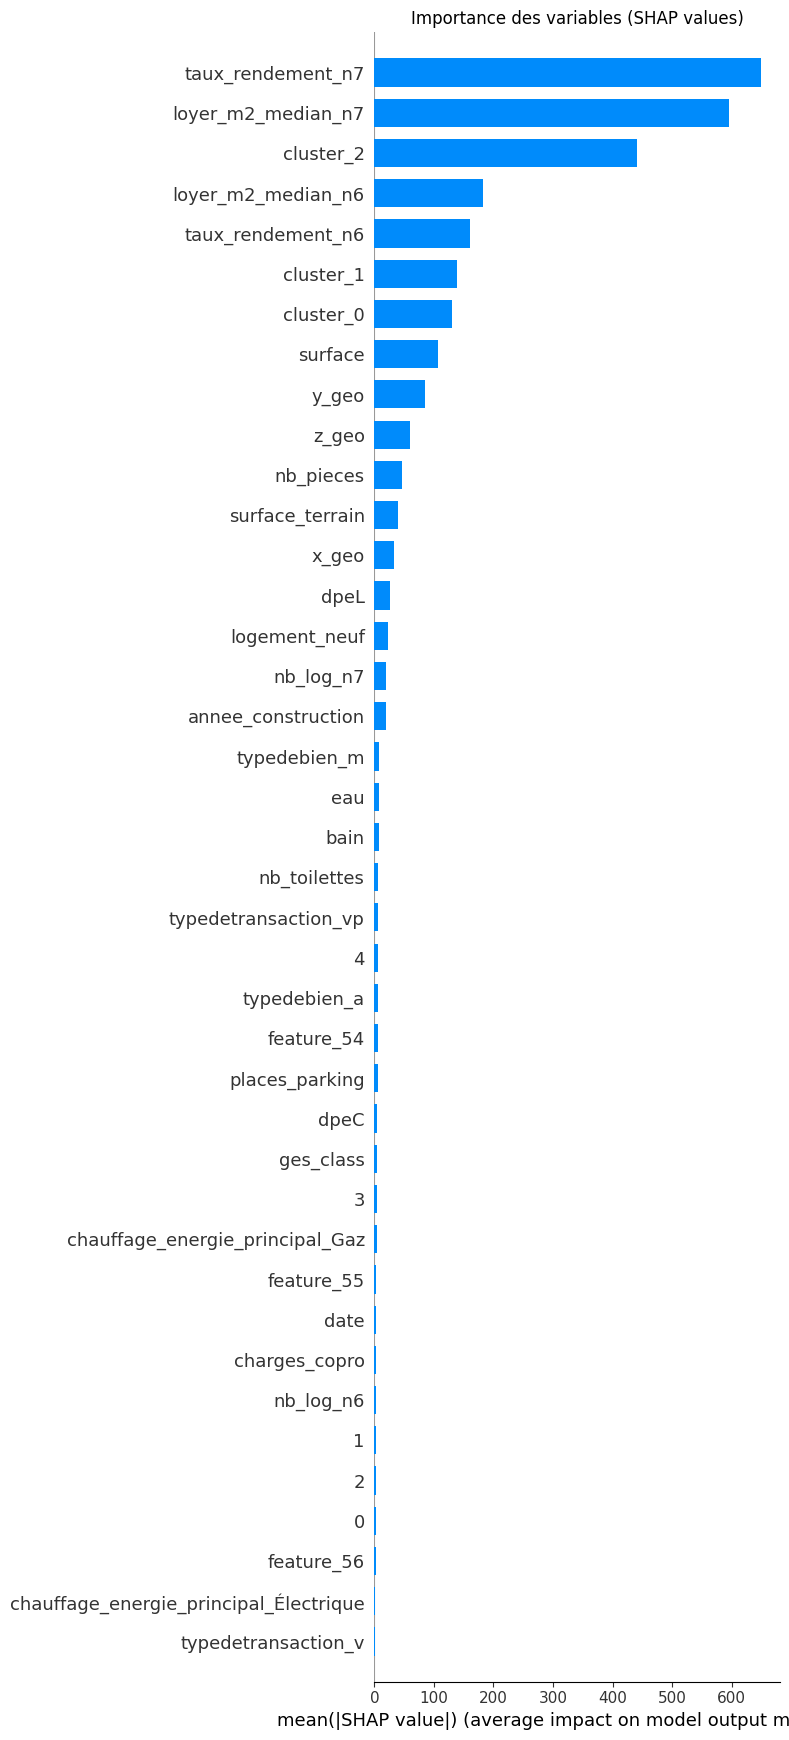

In [29]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1. Calcul des valeurs SHAP
explainer = shap.TreeExplainer(pipeline.named_steps["model"])
X_test_trans = pipeline.named_steps["preproc"].transform(X_test)
shap_values = explainer.shap_values(X_test_trans)

# 2. Récupération des noms de features après transformation
feature_names = get_feature_names_from_column_transformer(pipeline.named_steps["preproc"])
n_features = X_test_trans.shape[1]
if len(feature_names) < n_features:
    missing = n_features - len(feature_names)
    feature_names = list(feature_names) + [f"feature_{i}" for i in range(len(feature_names), n_features)]
    print(f"⚠️ {missing} noms de features manquants, complétés par des noms génériques.")

# 3. Affichage du summary plot SHAP (top 40)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_test_trans,
    feature_names=feature_names,
    plot_type='bar',
    max_display=40,
    show=False
)
plt.title("Importance des variables (SHAP values)")
plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import pandas as pd

# 1. Calcul de l'importance SHAP
shap_importance = np.abs(shap_values).mean(axis=0)
df_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": shap_importance
}).sort_values(by="importance", ascending=False)
top_40_features = df_importance["feature"].head(40).tolist()

# 2. Transformation des données
X_train_trans = pipeline.named_steps["preproc"].transform(X_train)
X_test_trans = pipeline.named_steps["preproc"].transform(X_test)

# 3. Conversion en DataFrame pour pouvoir sélectionner les colonnes par nom
X_train_trans_df = pd.DataFrame(X_train_trans, columns=feature_names)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

# 4. Sélection du top 40
X_train_40 = X_train_trans_df[top_40_features]
X_test_40 = X_test_trans_df[top_40_features]

# 5. Entraînement d'un modèle LightGBM sur ces features déjà transformées
from lightgbm import LGBMRegressor

model_40 = LGBMRegressor(random_state=42)
model_40.fit(X_train_40, y_train)
score_40 = model_40.score(X_test_40, y_test)
print(f"Score R² avec les 40 features les plus importantes : {score_40:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 818626, number of used features: 40
[LightGBM] [Info] Start training from score 3551.791223
Score R² avec les 40 features les plus importantes : 0.9559


# 10. Seuil optimal (max F1)

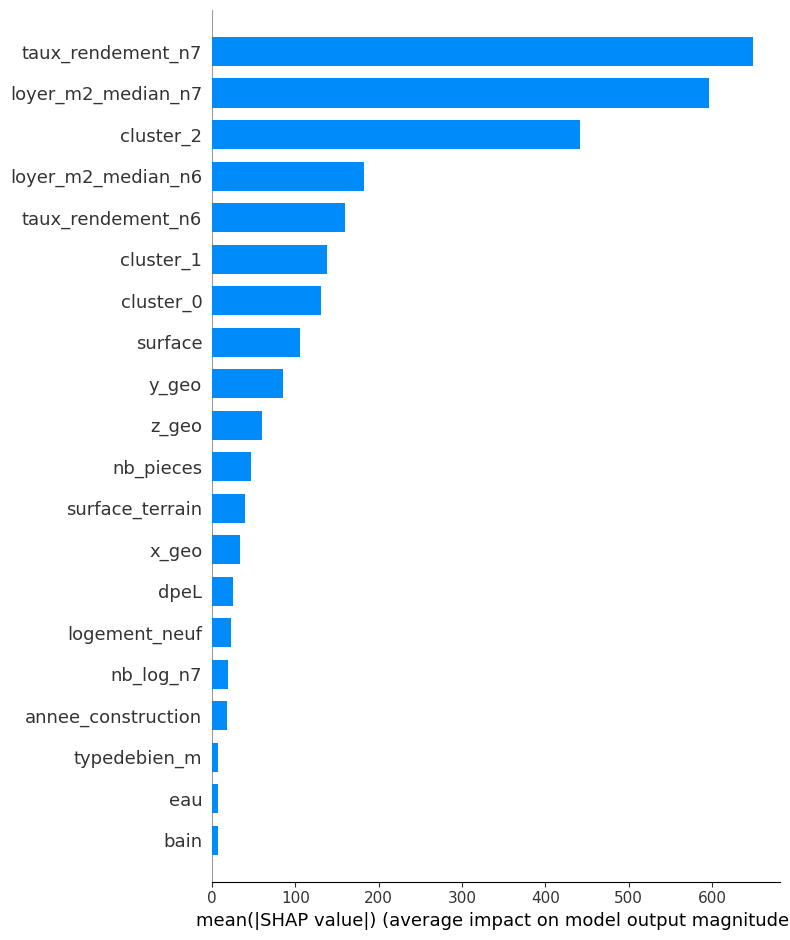

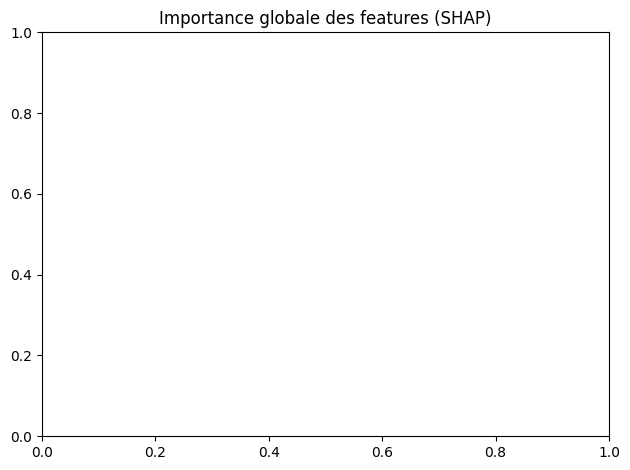

In [32]:
# Summary plot global
plt.figure(figsize=(10,6))
# Récupération des vrais noms de features après transformation
feature_names = get_feature_names_from_column_transformer(pipeline.named_steps["preproc"])
shap.summary_plot(
    shap_values, 
    X_test_trans, 
    feature_names=feature_names, 
    plot_type='bar', 
    max_display=20
)
plt.title("Importance globale des features (SHAP)")
plt.tight_layout()
plt.show()


# Sauvegarde

In [33]:
import joblib
import os

# Crée le dossier s'il n'existe pas
os.makedirs("models", exist_ok=True)

# Sauvegarde du modèle LightGBM entraîné sur les 40 features
joblib.dump(model_40, "models/lgbm_40features_deploy.pkl")
print("\n✅ Modèle 40 features sauvegardé sous 'models/lgbm_40features_deploy.pkl'")

# Sauvegarde la liste des features utilisées
joblib.dump(top_40_features, "models/features_40.pkl")
print("✅ Liste des 40 features sauvegardée sous 'models/features_40.pkl'")


✅ Modèle 40 features sauvegardé sous 'models/lgbm_40features_deploy.pkl'
✅ Liste des 40 features sauvegardée sous 'models/features_40.pkl'


In [14]:
# Crée le dossier s'il n'existe pas
os.makedirs("models", exist_ok=True)

# Sauvegarde du modèle
joblib.dump(pipeline, "models/lgbm_final_deploy.pkl")
print("\n✅ Modèle final sauvegardé sous 'models/lgbm_final_deploy.pkl'")


✅ Modèle final sauvegardé sous 'models/lgbm_final_deploy.pkl'
